# Antarctic SMB trends with sea level pressure and temperature trends

Author: Ziqi Yin

Last edited: Jun 14, 2025

## Description

- Data:
    - ERA5 reanalysis
    - CESM2-WNUDGE: constrain model to observed Antarctic winds
    - CESM2-LEcmip6: Large Ensemble (LE) using the 50 members that have original CMIP6 biomass burning aerosols
- Period: 2001-2022

In [1]:
# Load Libraries
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cartopy.util as util
import xarray as xr
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from scipy.stats import linregress
import matplotlib.path as mpath
import matplotlib.colors as colors

import sys  
home_dir = '/glade/work/ziqiyin/'
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')

from functions import *

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/ziqiyin/conda-envs/my-npl-202306a/share/proj failed


## Read data

In [5]:
## SMB variables
# ERA5 (1940-2023)
path = '/glade/work/dschneid/ERA5/ERA5/'

fn_SMB_ERA5 = 'era5_surface_monthly_45S90S_total_precipitation_and_evaportation_194001_202312.nc'
tp_ERA5 = xr.open_dataset(path+fn_SMB_ERA5).tp.sum(dim='expver') #[mwe], accumulation period is 1 day
e_ERA5 = xr.open_dataset(path+fn_SMB_ERA5).e.sum(dim='expver')
lon_era5 = tp_ERA5.longitude
lat_era5 = tp_ERA5.latitude
SMB_ERA5 = tp_ERA5 + e_ERA5

# CESM2-LE (50 cmip6 members, 1850-2100)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/large_ensemble_CESM2/CMIP6_subset/'

fn_RAIN_LE = 'b.e21.BHISTcmip6.f09_g17.LE2.EM1-50.clm2.h0.RAIN.185001-210012.nc'
RAIN_LE = xr.open_dataset(path+fn_RAIN_LE).RAIN #[mm/s]
fn_SNOW_LE = 'b.e21.BHISTcmip6.f09_g17.LE2.EM1-50.clm2.h0.SNOW.185001-210012.nc'
SNOW_LE = xr.open_dataset(path+fn_SNOW_LE).SNOW
fn_QSOIL_LE = 'b.e21.BHISTcmip6.f09_g17.LE2.EM1-50.clm2.h0.QSOIL.185001-210012.nc'
QSOIL_LE = xr.open_dataset(path+fn_QSOIL_LE).QSOIL
fn_QRUNOFF_LE = 'b.e21.BHISTcmip6.f09_g17.LE2.EM1-50.clm2.h0.QRUNOFF.185001-210012.nc'
QRUNOFF_LE = xr.open_dataset(path+fn_QRUNOFF_LE).QRUNOFF
SMB_LE = RAIN_LE + SNOW_LE - QSOIL_LE - QRUNOFF_LE
lon = RAIN_LE.lon
lat = RAIN_LE.lat

#CESM2-WNUDGE (1950-2024), BSSP370?
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/wind_nudged5580S_Ed1/'

fn_RAIN_WNUDGE = 'cesm2.1.3_BSSP370cmip6_f09_g17_ERA5_nudge.clm2.h0.RAIN.195001-202412.nc'
RAIN_WNUDGE = xr.open_dataset(path+fn_RAIN_WNUDGE).RAIN
fn_SNOW_WNUDGE = 'cesm2.1.3_BSSP370cmip6_f09_g17_ERA5_nudge.clm2.h0.SNOW.195001-202412.nc'
SNOW_WNUDGE = xr.open_dataset(path+fn_SNOW_WNUDGE).SNOW
fn_QSOIL_WNUDGE = 'cesm2.1.3_BSSP370cmip6_f09_g17_ERA5_nudge.clm2.h0.QSOIL.195001-202412.nc'
QSOIL_WNUDGE = xr.open_dataset(path+fn_QSOIL_WNUDGE).QSOIL
fn_QRUNOFF_WNUDGE = 'cesm2.1.3_BSSP370cmip6_f09_g17_ERA5_nudge.clm2.h0.QRUNOFF.195001-202412.nc'
QRUNOFF_WNUDGE = xr.open_dataset(path+fn_QRUNOFF_WNUDGE).QRUNOFF
SMB_WNUDGE = RAIN_WNUDGE + SNOW_WNUDGE - QSOIL_WNUDGE - QRUNOFF_WNUDGE

In [2]:
## PSL
# ERA5 (1940-2023)
path = '/glade/work/dschneid/ERA5/ERA5/'

fn_PSL_ERA5 = 'era5_monthly_PSL_194001_202401_last2monthsbad.nc'
msl_ERA5 = xr.open_dataset(path+fn_PSL_ERA5).msl.sum(dim='expver').sel(latitude=slice(-45, -90)) #[Pa]

In [3]:
#CESM2-LE (50 cmip6 members, 1850-2100)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/large_ensemble_CESM2/CMIP6_subset/'

fn_PSL_LE = 'b.e21.BHISTcmip6.f09_g17.LE2.EM1-50.cam.h0.PSL.185001-210012.nc'
PSL_LE = xr.open_dataset(path+fn_PSL_LE).PSL #[Pa]

In [4]:
#CESM2-WNUDGE (1950-2024)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/wind_nudged5580S_Ed1/'

fn_PSL_WNUDGE = 'cesm2.1.3_BSSP370cmip6_f09_g17_ERA5_nudge.cam.h0.PSL.195001-202412.nc'
PSL_WNUDGE = xr.open_dataset(path+fn_PSL_WNUDGE).PSL #[Pa]

In [ ]:
## PSL
# ERA5 (1940-2023)
path = '/glade/work/dschneid/ERA5/ERA5/'

fn_PSL_ERA5 = 'era5_monthly_PSL_194001_202401_last2monthsbad.nc'
msl_ERA5 = xr.open_dataset(path+fn_PSL_ERA5).msl.sum(dim='expver').sel(latitude=slice(-45, -90)) #[Pa]

#CESM2-LE (50 cmip6 members, 1850-2100)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/large_ensemble_CESM2/CMIP6_subset/'

fn_PSL_LE = 'b.e21.BHISTcmip6.f09_g17.LE2.EM1-50.cam.h0.PSL.185001-210012.nc'
PSL_LE = xr.open_dataset(path+fn_PSL_LE).PSL #[Pa]

#CESM2-WNUDGE (1950-2024)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/wind_nudged5580S_Ed1/'

fn_PSL_WNUDGE = 'cesm2.1.3_BSSP370cmip6_f09_g17_ERA5_nudge.cam.h0.PSL.195001-202412.nc'
PSL_WNUDGE = xr.open_dataset(path+fn_PSL_WNUDGE).PSL #[Pa]

In [7]:
## SAT
# ERA5 (1940-2024)
path = '/glade/work/dschneid/ERA5/ERA5/'

fn_SAT_ERA5 = 'era5_surface_monthly_t2m_194001_202412.nc'
SAT_ERA5 = xr.open_dataset(path+fn_SAT_ERA5).t2m.sel(latitude=slice(-45, -90)) #[K]

# CESM2-WNUDGE (1950-2024)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/wind_nudged5580S_Ed1/'

fn_SAT_WNUDGE = 'cesm2.1.3_BSSP370cmip6_f09_g17_ERA5_nudge.cam.h0.TREFHT.195001-202412.nc'
SAT_WNUDGE = xr.open_dataset(path+fn_SAT_WNUDGE).TREFHT #[K]

# CESM2-LE (50 cmip6 members, 1850-2100)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/large_ensemble_CESM2/CMIP6_subset/'

fn_SAT_LE = 'b.e21.BHISTcmip6.f09_g17.LE2.EM1-50.cam.h0.TREFHT.185001-210012.nc'
SAT_LE = xr.open_dataset(path+fn_SAT_LE).TREFHT #[K]

In [8]:
# Rearrange the longitude for msl_ERA5 and SAT_ERA5, from [0~360] to [-180~180]
lon_era5_new = msl_ERA5.longitude.where(msl_ERA5.longitude<180, msl_ERA5.longitude-360)
msl_ERA5['longitude'] = lon_era5_new
msl_ERA5_rearrange = msl_ERA5.sortby(msl_ERA5.longitude)
SAT_ERA5['longitude'] = lon_era5_new
SAT_ERA5_rearrange = SAT_ERA5.sortby(SAT_ERA5.longitude)

In [9]:
## Mask
# Zwally grounded ice sheet land mask (REMOVAL of ice shelves)
path = '/glade/work/dschneid/zaria_snow/'

fn_GROUNDEDMASK = 'AIS_Groundedmask_Zwally_CESMgrid.nc'
GROUNDEDMASK = xr.open_dataset(path+fn_GROUNDEDMASK).Groundedmask

# ERA5 masks
path = '/glade/work/ziqiyin/masks/AIS/model_mask/'

fn = 'ERA_masks.nc'
DS = xr.open_dataset(path+fn).sel(lat=slice(-20,-90))
GROUNDEDMASK_ERA5 = DS.grounded_ism[-181:, :] #grounded ice sheet

In [10]:
## Correct time
dates = pd.date_range("1850-01-01", periods=251*12, freq='ME')
SMB_LE['time'] = dates
PSL_LE['time'] = dates
SAT_LE['time'] = dates

dates = pd.date_range("1950-01-01", periods=75*12, freq='ME')
SMB_WNUDGE['time'] = dates
PSL_WNUDGE['time'] = dates
SAT_WNUDGE['time'] = dates

In [11]:
## Select time period
SMB_ERA5 = SMB_ERA5.sel(time=slice("2001-01-01", "2022-12-31"))
SMB_LE = SMB_LE.sel(time=slice("2001-01-01", "2022-12-31"))
SMB_WNUDGE = SMB_WNUDGE.sel(time=slice("2001-01-01", "2022-12-31"))
msl_ERA5_rearrange = msl_ERA5_rearrange.sel(time=slice("2001-01-01", "2022-12-31"))
PSL_LE = PSL_LE.sel(time=slice("2001-01-01", "2022-12-31"))
PSL_WNUDGE = PSL_WNUDGE.sel(time=slice("2001-01-01", "2022-12-31"))
SAT_ERA5_rearrange = SAT_ERA5_rearrange.sel(valid_time=slice("2001-01-01", "2022-12-31"))
SAT_LE = SAT_LE.sel(time=slice("2001-01-01", "2022-12-31"))
SAT_WNUDGE = SAT_WNUDGE.sel(time=slice("2001-01-01", "2022-12-31"))

## Calculate

In [12]:
## Calculate yearly mean SMB over the grounded ice sheet
# Plot period 2001-2022
days_in_month = SMB_ERA5.time.dt.days_in_month
year = SMB_ERA5.time.dt.year
SMB_ERA5_proj_monthly = SMB_ERA5 *(10**3) #[mmwe/day]
SMB_ERA5_proj_yearly = (SMB_ERA5_proj_monthly * GROUNDEDMASK_ERA5.values * days_in_month).groupby(year).sum() #[mm/yr]

days_in_month = SMB_LE.time.dt.days_in_month
year = SMB_LE.time.dt.year
SMB_LE_proj_monthly = SMB_LE #[mm/s]
SMB_LE_proj_yearly = (SMB_LE_proj_monthly * GROUNDEDMASK.values * days_in_month * (24*3600)).groupby(year).sum() #[mm/yr]

days_in_month = SMB_WNUDGE.time.dt.days_in_month
year = SMB_WNUDGE.time.dt.year
SMB_WNUDGE_proj_monthly = SMB_WNUDGE #[mm/s]
SMB_WNUDGE_proj_yearly = (SMB_WNUDGE_proj_monthly * GROUNDEDMASK.values * days_in_month * (24*3600)).groupby(year).sum() #[mm/yr]

In [13]:
## Calculate yearly mean PSL
# Plot period 2001-2022
days_in_month = msl_ERA5_rearrange.time.dt.days_in_month
year = msl_ERA5_rearrange.time.dt.year
msl_ERA5_proj_monthly = msl_ERA5_rearrange #[Pa]
msl_ERA5_proj_yearly = (msl_ERA5_proj_monthly * days_in_month).groupby(year).sum() /365 #[Pa]

days_in_month = PSL_LE.time.dt.days_in_month
year = PSL_LE.time.dt.year
PSL_LE_proj_monthly = PSL_LE #[Pa]
PSL_LE_proj_yearly = (PSL_LE_proj_monthly * days_in_month).groupby(year).sum() /365 #[Pa]

days_in_month = PSL_WNUDGE.time.dt.days_in_month
year = PSL_WNUDGE.time.dt.year
PSL_WNUDGE_proj_monthly = PSL_WNUDGE #[Pa]
PSL_WNUDGE_proj_yearly = (PSL_WNUDGE_proj_monthly * days_in_month).groupby(year).sum() /365 #[Pa]

In [14]:
## Calculate yearly mean SAT
# Plot period 2001-2022
days_in_month = SAT_ERA5_rearrange.valid_time.dt.days_in_month
year = SAT_ERA5_rearrange.valid_time.dt.year
SAT_ERA5_proj_monthly = SAT_ERA5_rearrange #[K]
SAT_ERA5_proj_yearly = (SAT_ERA5_proj_monthly * days_in_month).groupby(year).sum() /365 #[K]

days_in_month = SAT_LE.time.dt.days_in_month
year = SAT_LE.time.dt.year
SAT_LE_proj_monthly = SAT_LE #[K]
SAT_LE_proj_yearly = (SAT_LE_proj_monthly * days_in_month).groupby(year).sum() /365 #[Pa]

days_in_month = SAT_WNUDGE.time.dt.days_in_month
year = SAT_WNUDGE.time.dt.year
SAT_WNUDGE_proj_monthly = SAT_WNUDGE #[Pa]
SAT_WNUDGE_proj_yearly = (SAT_WNUDGE_proj_monthly * days_in_month).groupby(year).sum() /365 #[Pa]

In [15]:
##Linear Regression of SMB
#ERA5
year = np.arange(2001, 2023)
slope_SMB_ERA5_2001_2022 = SMB_ERA5_proj_yearly[0,:,:]*0

for i in range(181):
    for j in range(1440):
        slope, intercept, r, p, se = linregress(year, SMB_ERA5_proj_yearly[:,i,j])
        slope_SMB_ERA5_2001_2022[i,j] = slope

#CESM2-LE cmip6 members
year = np.arange(2001, 2023)
slope_SMB_LE_2001_2022 = SMB_LE_proj_yearly[0,:,:]*0

for i in range(192):
    for j in range(288):
        slope, intercept, r, p, se = linregress(year, SMB_LE_proj_yearly[:,i,j])
        slope_SMB_LE_2001_2022[i,j] = slope

#CESM2-WNUDGE
year = np.arange(2001, 2023)
slope_SMB_WNUDGE_2001_2022 = SMB_WNUDGE_proj_yearly[0,:,:]*0

for i in range(192):
    for j in range(288):
        slope, intercept, r, p, se = linregress(year, SMB_WNUDGE_proj_yearly[:,i,j])
        slope_SMB_WNUDGE_2001_2022[i,j] = slope

In [16]:
##Linear Regression of PSL
#ERA5
year = np.arange(2001, 2023)
slope_msl_ERA5_2001_2022 = msl_ERA5_proj_yearly[0,:,:]*0

for i in range(181):
    for j in range(1440):
        slope, intercept, r, p, se = linregress(year, msl_ERA5_proj_yearly[:,i,j])
        slope_msl_ERA5_2001_2022[i,j] = slope

#CESM2-LE cmip6 members
year = np.arange(2001, 2023)
slope_PSL_LE_2001_2022 = PSL_LE_proj_yearly[0,:,:]*0

for i in range(192):
    for j in range(288):
        slope, intercept, r, p, se = linregress(year, PSL_LE_proj_yearly[:,i,j])
        slope_PSL_LE_2001_2022[i,j] = slope

#CESM2-WNUDGE
year = np.arange(2001, 2023)
slope_PSL_WNUDGE_2001_2022 = PSL_WNUDGE_proj_yearly[0,:,:]*0

for i in range(192):
    for j in range(288):
        slope, intercept, r, p, se = linregress(year, PSL_WNUDGE_proj_yearly[:,i,j])
        slope_PSL_WNUDGE_2001_2022[i,j] = slope

In [17]:
##Linear Regression of SAT
#ERA5
year = np.arange(2001, 2023)
slope_SAT_ERA5_2001_2022 = SAT_ERA5_proj_yearly[0,:,:]*0

for i in range(181):
    for j in range(1440):
        slope, intercept, r, p, se = linregress(year, SAT_ERA5_proj_yearly[:,i,j])
        slope_SAT_ERA5_2001_2022[i,j] = slope

#CESM2-LE cmip6 members
year = np.arange(2001, 2023)
slope_SAT_LE_2001_2022 = SAT_LE_proj_yearly[0,:,:]*0

for i in range(192):
    for j in range(288):
        slope, intercept, r, p, se = linregress(year, SAT_LE_proj_yearly[:,i,j])
        slope_SAT_LE_2001_2022[i,j] = slope

#CESM2-WNUDGE
year = np.arange(2001, 2023)
slope_SAT_WNUDGE_2001_2022 = SAT_WNUDGE_proj_yearly[0,:,:]*0

for i in range(192):
    for j in range(288):
        slope, intercept, r, p, se = linregress(year, SAT_WNUDGE_proj_yearly[:,i,j])
        slope_SAT_WNUDGE_2001_2022[i,j] = slope

In [18]:
#Add cyclic points
slope_SMB_ERA5_full_2001_2022, lon_era5_full = add_cyclic_point(slope_SMB_ERA5_2001_2022, coord=lon_era5)
slope_SMB_LE_full_2001_2022, lon_full = add_cyclic_point(slope_SMB_LE_2001_2022, coord=lon)
slope_SMB_WNUDGE_full_2001_2022, lon_full = add_cyclic_point(slope_SMB_WNUDGE_2001_2022, coord=lon)

slope_SMB_ERA5_full_2001_2022 = np.where(slope_SMB_ERA5_full_2001_2022 != 0, slope_SMB_ERA5_full_2001_2022, np.NaN)
slope_SMB_LE_full_2001_2022 = np.where(slope_SMB_LE_full_2001_2022 != 0, slope_SMB_LE_full_2001_2022, np.NaN)
slope_SMB_WNUDGE_full_2001_2022 = np.where(slope_SMB_WNUDGE_full_2001_2022 != 0, slope_SMB_WNUDGE_full_2001_2022, np.NaN)

In [19]:
#Add cyclic points
slope_msl_ERA5_full_2001_2022, lon_era5_full = add_cyclic_point(slope_msl_ERA5_2001_2022, coord=lon_era5)
slope_PSL_LE_full_2001_2022, lon_full = add_cyclic_point(slope_PSL_LE_2001_2022, coord=lon)
slope_PSL_WNUDGE_full_2001_2022, lon_full = add_cyclic_point(slope_PSL_WNUDGE_2001_2022, coord=lon)

slope_msl_ERA5_full_2001_2022 = np.where(slope_msl_ERA5_full_2001_2022 != 0, slope_msl_ERA5_full_2001_2022, np.NaN)
slope_PSL_LE_full_2001_2022 = np.where(slope_PSL_LE_full_2001_2022 != 0, slope_PSL_LE_full_2001_2022, np.NaN)
slope_PSL_WNUDGE_full_2001_2022 = np.where(slope_PSL_WNUDGE_full_2001_2022 != 0, slope_PSL_WNUDGE_full_2001_2022, np.NaN)

In [20]:
#Add cyclic points
slope_SAT_ERA5_full_2001_2022, lon_era5_full = add_cyclic_point(slope_SAT_ERA5_2001_2022, coord=lon_era5)
slope_SAT_LE_full_2001_2022, lon_full = add_cyclic_point(slope_SAT_LE_2001_2022, coord=lon)
slope_SAT_WNUDGE_full_2001_2022, lon_full = add_cyclic_point(slope_SAT_WNUDGE_2001_2022, coord=lon)

slope_SAT_ERA5_full_2001_2022 = np.where(slope_SAT_ERA5_full_2001_2022 != 0, slope_SAT_ERA5_full_2001_2022, np.NaN)
slope_SAT_LE_full_2001_2022 = np.where(slope_SAT_LE_full_2001_2022 != 0, slope_SAT_LE_full_2001_2022, np.NaN)
slope_SAT_WNUDGE_full_2001_2022 = np.where(slope_SAT_WNUDGE_full_2001_2022 != 0, slope_SAT_WNUDGE_full_2001_2022, np.NaN)

## Plot

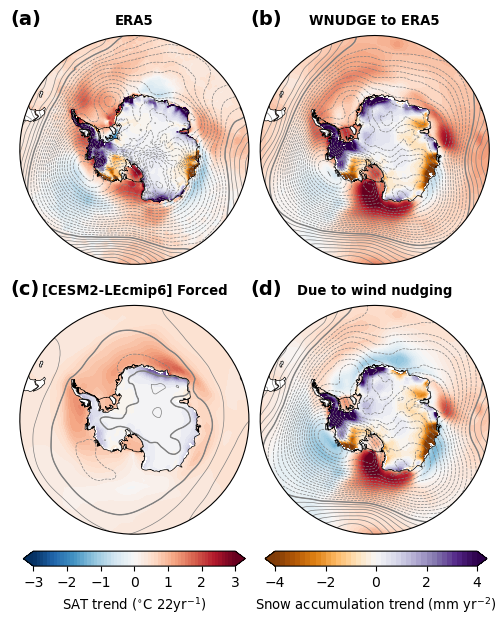

In [24]:
# Add SAT over ocean
fig=plt.figure(figsize=(6,7.5))
gs=GridSpec(2,2)
plt.rcParams['axes.titlepad']=14

level_SAT = np.arange(-3., 3.01, 0.1)
ticks_SAT = np.arange(-3., 3.01, 1.)

level_SMB = np.arange(-4, 4.1, 0.2)
ticks_SMB = np.arange(-4, 4.1, 2.)

level_PSL = np.arange(0-1.5*60, 0+1.5*61, 1.5)
level_PSL0 = np.arange(-100., 100.1, 100.)

size_title = 9.5
size_text = 14
size_label = 9.5
size_tick = 10
width_contour = 0.5

cmap1 = 'RdBu_r'
cmap2 = 'PuOr'

######################### Subplot1 #########################
ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax1, -50)

ax1.add_feature(cfeature.COASTLINE, lw=0.5, zorder=4)
ax1.add_feature(cfeature.LAND, facecolor='white', zorder=2)
im1a = ax1.contourf(lon_era5_full, lat_era5, slope_SAT_ERA5_full_2001_2022*22, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SAT, extend='both', zorder=1)
im1b = ax1.contourf(lon_era5_full, lat_era5, slope_SMB_ERA5_full_2001_2022, cmap=cmap2, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both', zorder=2)
im1c = ax1.contour(lon_era5_full, lat_era5, slope_msl_ERA5_full_2001_2022, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im1d = ax1.contour(lon_era5_full, lat_era5, slope_msl_ERA5_full_2001_2022, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)
#plt.clabel(im1b, level_PSL[1::2], fontsize=6)

ax1.text(-5100000, 5100000, '(a)', fontsize=size_text, fontweight='bold')
ax1.set_title('ERA5', pad=9, fontsize=size_title, fontweight='bold')

######################### Subplot2 #########################
ax2 = plt.subplot(gs[1], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax2, -50)

ax2.add_feature(cfeature.COASTLINE, lw=0.5, zorder=4)
ax2.add_feature(cfeature.LAND, facecolor='white', zorder=2)
im2a = ax2.contourf(lon_full, lat, slope_SAT_WNUDGE_full_2001_2022*22, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SAT, extend='both', zorder=1)
im2b = ax2.contourf(lon_full, lat, slope_SMB_WNUDGE_full_2001_2022, cmap=cmap2, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both', zorder=2)
im2c = ax2.contour(lon_full, lat, slope_PSL_WNUDGE_full_2001_2022, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im2d = ax2.contour(lon_full, lat, slope_PSL_WNUDGE_full_2001_2022, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)
#plt.clabel(im2b, level_PSL[1::2], fontsize=6)

ax2.text(-5100000, 5100000, '(b)', fontsize=size_text, fontweight='bold')
ax2.set_title('WNUDGE to ERA5', pad=9, fontsize=size_title, fontweight='bold')

######################### Subplot3 #########################
ax3 = plt.subplot(gs[2], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax3, -50)

ax3.add_feature(cfeature.COASTLINE, lw=0.5, zorder=4)
ax3.add_feature(cfeature.LAND, facecolor='white', zorder=2)
im3a = ax3.contourf(lon_full, lat, slope_SAT_LE_full_2001_2022*22, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SAT, extend='both', zorder=1)
im3b = ax3.contourf(lon_full, lat, slope_SMB_LE_full_2001_2022, cmap=cmap2, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both', zorder=2)
im3c = ax3.contour(lon_full, lat, slope_PSL_LE_full_2001_2022, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im3d = ax3.contour(lon_full, lat, slope_PSL_LE_full_2001_2022, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)
#plt.clabel(im3b, level_PSL[1::2], fontsize=6)

ax3.text(-5100000, 5100000, '(c)', fontsize=size_text, fontweight='bold')
ax3.set_title('[CESM2-LEcmip6] Forced', pad=9, fontsize=size_title, fontweight='bold')

######################### Subplot4 #########################
ax4 = plt.subplot(gs[3], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax4, -50)

ax4.add_feature(cfeature.COASTLINE, lw=0.5, zorder=4)
ax4.add_feature(cfeature.LAND, facecolor='white', zorder=2)
im4a = ax4.contourf(lon_full, lat, slope_SAT_WNUDGE_full_2001_2022*22-slope_SAT_LE_full_2001_2022*22, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SAT, extend='both', zorder=1)
im4b = ax4.contourf(lon_full, lat, slope_SMB_WNUDGE_full_2001_2022-slope_SMB_LE_full_2001_2022, cmap=cmap2, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both', zorder=2)
im4c = ax4.contour(lon_full, lat, slope_PSL_WNUDGE_full_2001_2022-slope_PSL_LE_full_2001_2022, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im4d = ax4.contour(lon_full, lat, slope_PSL_WNUDGE_full_2001_2022-slope_PSL_LE_full_2001_2022, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)
#plt.clabel(im4b, level_PSL[1::2], fontsize=6)

ax4.text(-5100000, 5100000, '(d)', fontsize=size_text, fontweight='bold')
ax4.set_title('Due to wind nudging', pad=9, fontsize=size_title, fontweight='bold')

#Colorbar
cbar1_ax = fig.add_axes([0.127, 0.16, 0.37, 0.02]) #[from left, from bottom, width, height]
cbar1 = fig.colorbar(im4a, cax=cbar1_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_SAT, ticks=ticks_SAT)
cbar1.ax.tick_params(labelsize=size_tick)
cbar1.set_label('SAT trend ($^{\circ}$C 22yr$^{-1}$)', size=size_label)

cbar2_ax = fig.add_axes([0.53, 0.16, 0.37, 0.02]) #[from left, from bottom, width, height]
cbar2 = fig.colorbar(im4b, cax=cbar2_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_SMB, ticks=ticks_SMB)
cbar2.ax.tick_params(labelsize=size_tick)
cbar2.set_label('Snow accumulation trend (mm yr$^{-2}$)', size=size_label)


plt.subplots_adjust(#left=0.1,
                    bottom=0.19,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.07,
                    hspace=0.09)

plt.savefig(
    'plot/F7_map_AIS_SMB_PSL_SAT_trend_2001_2022.jpg',
    dpi=500,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)

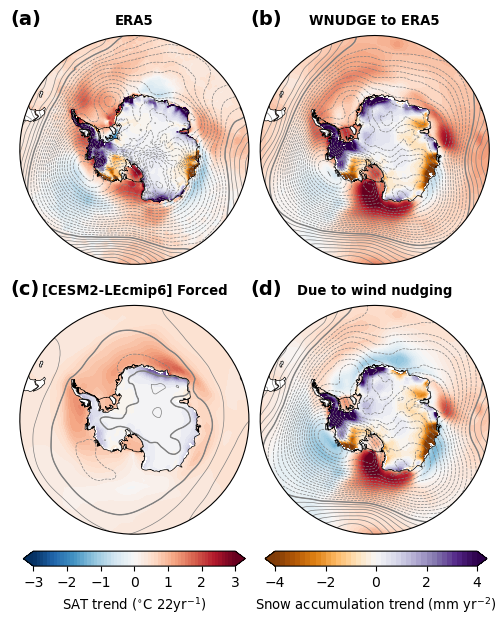

In [25]:
# Save in pdf format
fig=plt.figure(figsize=(6,7.5))
gs=GridSpec(2,2)
plt.rcParams['axes.titlepad']=14

level_SAT = np.arange(-3., 3.01, 0.1)
ticks_SAT = np.arange(-3., 3.01, 1.)

level_SMB = np.arange(-4, 4.1, 0.2)
ticks_SMB = np.arange(-4, 4.1, 2.)

level_PSL = np.arange(0-1.5*60, 0+1.5*61, 1.5)
level_PSL0 = np.arange(-100., 100.1, 100.)

size_title = 9.5
size_text = 14
size_label = 9.5
size_tick = 10
width_contour = 0.5

cmap1 = 'RdBu_r'
cmap2 = 'PuOr'

######################### Subplot1 #########################
ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax1, -50)

ax1.add_feature(cfeature.COASTLINE, lw=0.5, zorder=4)
ax1.add_feature(cfeature.LAND, facecolor='white', zorder=2)
im1a = ax1.contourf(lon_era5_full, lat_era5, slope_SAT_ERA5_full_2001_2022*22, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SAT, extend='both', zorder=1)
im1b = ax1.contourf(lon_era5_full, lat_era5, slope_SMB_ERA5_full_2001_2022, cmap=cmap2, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both', zorder=2)
im1c = ax1.contour(lon_era5_full, lat_era5, slope_msl_ERA5_full_2001_2022, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im1d = ax1.contour(lon_era5_full, lat_era5, slope_msl_ERA5_full_2001_2022, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)
#plt.clabel(im1b, level_PSL[1::2], fontsize=6)

ax1.text(-5100000, 5100000, '(a)', fontsize=size_text, fontweight='bold')
ax1.set_title('ERA5', pad=9, fontsize=size_title, fontweight='bold')

######################### Subplot2 #########################
ax2 = plt.subplot(gs[1], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax2, -50)

ax2.add_feature(cfeature.COASTLINE, lw=0.5, zorder=4)
ax2.add_feature(cfeature.LAND, facecolor='white', zorder=2)
im2a = ax2.contourf(lon_full, lat, slope_SAT_WNUDGE_full_2001_2022*22, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SAT, extend='both', zorder=1)
im2b = ax2.contourf(lon_full, lat, slope_SMB_WNUDGE_full_2001_2022, cmap=cmap2, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both', zorder=2)
im2c = ax2.contour(lon_full, lat, slope_PSL_WNUDGE_full_2001_2022, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im2d = ax2.contour(lon_full, lat, slope_PSL_WNUDGE_full_2001_2022, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)
#plt.clabel(im2b, level_PSL[1::2], fontsize=6)

ax2.text(-5100000, 5100000, '(b)', fontsize=size_text, fontweight='bold')
ax2.set_title('WNUDGE to ERA5', pad=9, fontsize=size_title, fontweight='bold')

######################### Subplot3 #########################
ax3 = plt.subplot(gs[2], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax3, -50)

ax3.add_feature(cfeature.COASTLINE, lw=0.5, zorder=4)
ax3.add_feature(cfeature.LAND, facecolor='white', zorder=2)
im3a = ax3.contourf(lon_full, lat, slope_SAT_LE_full_2001_2022*22, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SAT, extend='both', zorder=1)
im3b = ax3.contourf(lon_full, lat, slope_SMB_LE_full_2001_2022, cmap=cmap2, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both', zorder=2)
im3c = ax3.contour(lon_full, lat, slope_PSL_LE_full_2001_2022, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im3d = ax3.contour(lon_full, lat, slope_PSL_LE_full_2001_2022, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)
#plt.clabel(im3b, level_PSL[1::2], fontsize=6)

ax3.text(-5100000, 5100000, '(c)', fontsize=size_text, fontweight='bold')
ax3.set_title('[CESM2-LEcmip6] Forced', pad=9, fontsize=size_title, fontweight='bold')

######################### Subplot4 #########################
ax4 = plt.subplot(gs[3], projection=ccrs.SouthPolarStereo())
plot_antarctica(ax4, -50)

ax4.add_feature(cfeature.COASTLINE, lw=0.5, zorder=4)
ax4.add_feature(cfeature.LAND, facecolor='white', zorder=2)
im4a = ax4.contourf(lon_full, lat, slope_SAT_WNUDGE_full_2001_2022*22-slope_SAT_LE_full_2001_2022*22, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SAT, extend='both', zorder=1)
im4b = ax4.contourf(lon_full, lat, slope_SMB_WNUDGE_full_2001_2022-slope_SMB_LE_full_2001_2022, cmap=cmap2, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both', zorder=2)
im4c = ax4.contour(lon_full, lat, slope_PSL_WNUDGE_full_2001_2022-slope_PSL_LE_full_2001_2022, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im4d = ax4.contour(lon_full, lat, slope_PSL_WNUDGE_full_2001_2022-slope_PSL_LE_full_2001_2022, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)
#plt.clabel(im4b, level_PSL[1::2], fontsize=6)

ax4.text(-5100000, 5100000, '(d)', fontsize=size_text, fontweight='bold')
ax4.set_title('Due to wind nudging', pad=9, fontsize=size_title, fontweight='bold')

#Colorbar
cbar1_ax = fig.add_axes([0.127, 0.16, 0.37, 0.02]) #[from left, from bottom, width, height]
cbar1 = fig.colorbar(im4a, cax=cbar1_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_SAT, ticks=ticks_SAT)
cbar1.ax.tick_params(labelsize=size_tick)
cbar1.set_label('SAT trend ($^{\circ}$C 22yr$^{-1}$)', size=size_label)

cbar2_ax = fig.add_axes([0.53, 0.16, 0.37, 0.02]) #[from left, from bottom, width, height]
cbar2 = fig.colorbar(im4b, cax=cbar2_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_SMB, ticks=ticks_SMB)
cbar2.ax.tick_params(labelsize=size_tick)
cbar2.set_label('Snow accumulation trend (mm yr$^{-2}$)', size=size_label)


plt.subplots_adjust(#left=0.1,
                    bottom=0.19,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.07,
                    hspace=0.09)

plt.savefig(
    "plot/F7_map_AIS_SMB_PSL_SAT_trend_2001_2022.pdf",
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)

## Save

In [49]:
# Create xarray DataArray
slope_SAT = xr.DataArray(
    slope_SAT_WNUDGE_full_2001_2022[:,:-1]*22,
    dims=["lat", "lon"],
    coords={"lat": lat, "lon": lon},
    name="SAT_trend",
    attrs=dict(
        description="Surface air temperature trend over 2001-2022",
        units="degC/22yrs",
    ),
)

slope_SMB = xr.DataArray(
    slope_SMB_WNUDGE_full_2001_2022[:,:-1],
    dims=["lat", "lon"],
    coords={"lat": lat, "lon": lon},
    name="SMB_trend",
    attrs=dict(
        description="Snow accumulation trend over 2001-2022",
        units="mm/yr2",
    ),
)

slope_PSL = xr.DataArray(
    slope_PSL_WNUDGE_full_2001_2022[:,:-1],
    dims=["lat", "lon"],
    coords={"lat": lat, "lon": lon},
    name="PSL_trend",
    attrs=dict(
        description="Sea level pressure trend over 2001-2022",
        units="Pa/yr",
    ),
)

In [50]:
# Save to NetCDF (45-90S)
slope_SAT.sel(lat=slice(-90, -45)).to_netcdf("SAT_trend_WNUDGE_2001_2022_45S_90S.nc")
slope_SMB.sel(lat=slice(-90, -45)).to_netcdf("SMB_trend_WNUDGE_2001_2022_45S_90S.nc")
slope_PSL.sel(lat=slice(-90, -45)).to_netcdf("PSL_trend_WNUDGE_2001_2022_45S_90S.nc")

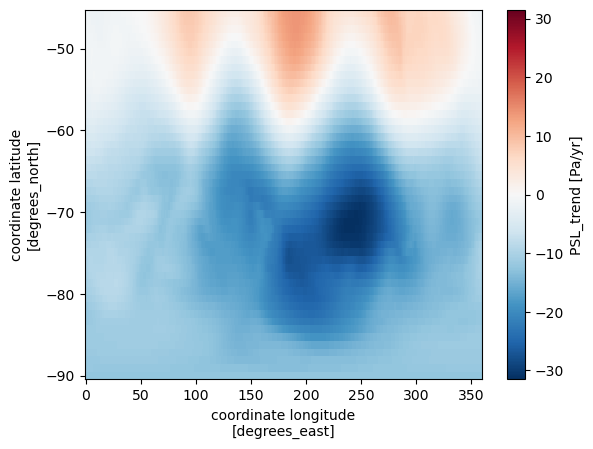

In [51]:
# Test
xr.open_dataset("PSL_trend_WNUDGE_2001_2022_45S_90S.nc").PSL_trend.plot();